In [1]:
%matplotlib notebook
from pyluos import Device
from IPython.display import clear_output
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# 1. Connect your Luos network (here using an USB module for example)
r = Device('COM6')
print(r.services)

# 2. Select the module of your network you need to configure
module = r.servo_motor

# 3. Setup motor module basic settings
module.encoder_res = 12
module.reduction = 74.83

SAMPLERATE = 1.0/module.sampling_freq

def run_speed_test(velocity_target):
    module.rot_position = False
    module.rot_speed = True
    module.current = True
    module.rot_position_mode = False
    module.rot_speed_mode = True
    module.target_rot_speed = 0.0
    module.compliant = False
    target = []
    real = []
    current = []
    test_time_vector = []
    test_start_time = time.time()
    target.append(module.target_rot_speed)
    real.append(module.rot_speed)
    current.append(module.current)
    test_time = time.time()
    test_time_vector.append(0.0)
    while (test_time < test_start_time + 0.5):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_speed)
        real.append(module.rot_speed)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.target_rot_speed = velocity_target
    while (test_time < test_start_time + 2.5):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_speed)
        real.append(module.rot_speed)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.compliant = True
    plot_test(test_time_vector, target, real, current)

def run_pos_test():
    module.rot_speed = False
    module.rot_position = True
    module.current = True
    module.rot_speed_mode = False
    module.rot_position_mode = True
    module.target_rot_position = 0.0
    module.compliant = False
    target = []
    real = []
    current = []
    test_time_vector = []
    test_start_time = time.time()
    target.append(module.target_rot_position)
    real.append(module.rot_position)
    current.append(module.current)
    test_time = time.time()
    test_time_vector.append(0.0)
    while (test_time < test_start_time + 1):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_position)
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.target_rot_position = 90.0
    while (test_time < test_start_time + 2.5):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_position)
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
        
    # create a smooth trajectory
    moveduration = 2
    keypoints = np.array([90, 4, -10, -33, -87, -87, 10, -80, 0])
    x = np.linspace(0, 1, keypoints.shape[-1], endpoint=True)
    traj = interp1d(x, keypoints, 'cubic')(np.linspace(0, 1, int(moveduration*module.sampling_freq)))
    #send traj to motor
    module.target_rot_position = traj
    # wait a bit for the motor to start
    time.sleep(0.03)
    traj_start_time = time.time()
    for i, sample in enumerate(traj):
        target.append(sample)
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        #time.sleep(1.0/module.sampling_freq)
        while(time.time() < traj_start_time + SAMPLERATE*(i+1)):
            time.sleep(0.004)
        test_time = time.time()
    traj_start_time = time.time()
    test_time = time.time()
    while (test_time < traj_start_time + 0.5):
        time.sleep(SAMPLERATE)
        target.append(traj[len(traj)-1])
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.compliant = True
    plot_test(test_time_vector, target, real, current)

def plot_test(test_time_vector, target, real, current):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel('Time (s)')
    ax.plot(test_time_vector,target,'r', label='Target')
    ax.plot(test_time_vector,real,'b', label='Real')
    ax.legend(loc='upper left')
    ax1 = ax.twinx()
    ax1.set_ylabel('Current (A)')
    ax1.plot(test_time_vector,current,'g', label='Current')
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.legend(loc='upper right')
    plt.show()
    
    #fig2 = plt.figure()
    #ax = plt.subplot(111)
    #plt.show()
    
#motor wiring test
def wiring_test():
    module.setToZero()
    module.power_mode = True
    module.compliant = False
    module.power_ratio = 100.0
    time.sleep(0.5)
    module.power_ratio = 0
    module.compliant = True
    if (module.rot_position > 1):
        print("Connection OK")
    else :
        print("Connection not OK. If the motor moved plese check your sensor connection or reverse it.")

Connected to "COM6".
Sending detection signal.
Waiting for routing table...
Device setup.
-------------------------------------------------
Type                Alias               ID   
-------------------------------------------------
Gate                gate                1    
Pipe                Pipe                2    
ServoMotor          servo_motor         3    



In [2]:
# test motor connections
wiring_test()

Connection OK


In [3]:
# Test position setting
module.positionPid = [30.0, 0.1, 100.0] # position PID [P, I, D]
module.rot_speed = False
module.rot_position = True
module.current = True
module.rot_speed_mode = False
module.rot_position_mode = True
module.target_rot_position = 0.0
module.compliant = False

module.target_rot_position = -360.0
time.sleep(1)
module.target_rot_position = 360.0
time.sleep(1)


<IPython.core.display.Javascript object>


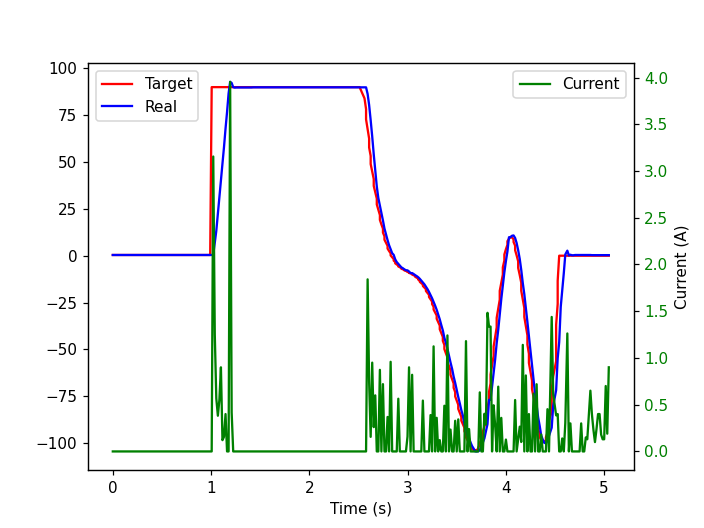

In [7]:
# Test trajectory
module.positionPid = [28.0, 0.1, 100.0] # position PID [P, I, D]
run_pos_test()

In [5]:
# read position
while(True):
    clear_output(wait=True)
    print("\nmotor (",r.servo_motor.refresh_freq, "Hz) : ",
        "\n\tposition : ", r.servo_motor.rot_position
        #"\n\tspeed : ", r.servo_motor.rot_speed
            )
    time.sleep(0.005)


motor ( 464.54902219982415 Hz) :  
	position :  0.217


KeyboardInterrupt: 